<h2>Transfer Learning with Convolutional Neural Networks For Classification with PyTorch and   <a href="https://vision.skills.network"> Computer Vision Learning 
Studio
 (CV Studio)</a></h2> <p><b> V 0.2</b></p>
<h4>Project: Intel Natural Scene Classification</h4>
<h4>Training Run: CNN_Natural Scene Classification</h4>


* * *


## Import Libraries and Define Auxiliary Functions


In [1]:
#! conda install -c pytorch torchvision
#! pip install skillsnetwork tqdm
#!pip install  skillsnetwork

Libraries for OS and Cloud


In [2]:
import os
import uuid
import shutil
import json
from botocore.client import Config
import ibm_boto3
import copy
from datetime import datetime
from skillsnetwork import cvstudio 

Libraries for Data Processing and Visualization


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
from ipywidgets import IntProgress
import time 

Deep Learning Libraries


In [4]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

Plot train cost and validation accuracy:


In [5]:
def plot_stuff(COST,ACC):    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

Plot the transformed image:


In [6]:
def imshow_(inp, title=None):
    """Imshow for Tensor."""
    inp = inp .permute(1, 2, 0).numpy() 
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()

Compare the prediction and actual value:


In [7]:
def result(model,x,y):
    #x,y=sample
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)
    
    if yhat.item()!=y:
        text="predicted: {} actual: {}".format(str(yhat.item()),y)
        print(text)

Define our device as the first visible cuda device if we have CUDA available:


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)


the device type is cpu


## Load Data


In this section we will preprocess our dataset by changing the shape of the image, converting to tensor and normalizing the image channels. These are the default preprocessing steps for image data. In addition, we will perform data augmentation on the training dataset. The preprocessing steps for the test dataset is the same, but W do not prform data augmentation on the test dataset. 


Download the data:


In [9]:

# Get the Dataset
# Initialize the CV Studio Client
cvstudioClient = cvstudio.CVStudio()
# # Download All Images
cvstudioClient.downloadAll()

100%|██████████| 300/300 [01:14<00:00,  4.03it/s]


We need to get our training and validation dataset. 90% of the data will be used for training.


In [10]:
percentage_train=0.9
train_set=cvstudioClient.getDataset(train_test='train',percentage_train=percentage_train)
val_set=cvstudioClient.getDataset(train_test='test',percentage_train=percentage_train)

defult transform for pretrained model resnet18
this is the training set
defult transform for pretrained model resnet18
this is the test set


We can plot some of our dataset:


(224, 224, 3)


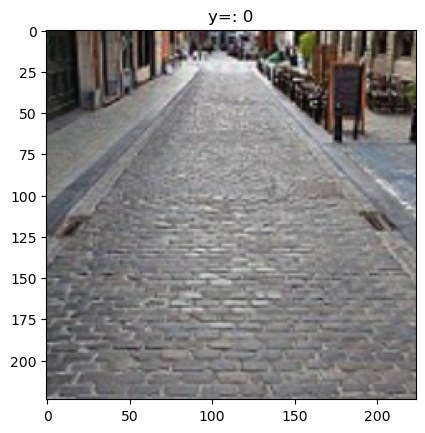

(224, 224, 3)


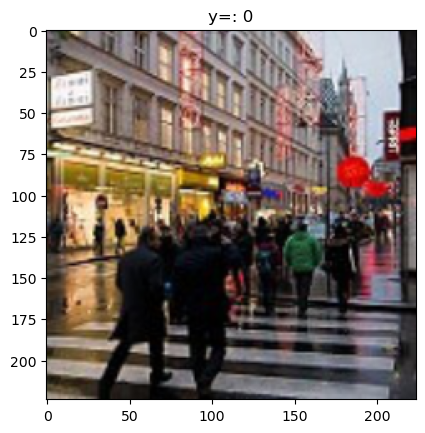

(224, 224, 3)


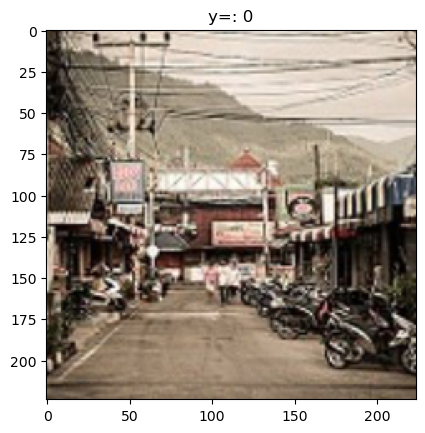

In [11]:
i=0

for x,y  in val_set:
    imshow_(x,"y=: {}".format(str(y.item())))
    i+=1
    if i==3:
        break

## Hyperparameters


In [12]:
n_epochs=50
batch_size=32
lr=0.000001
momentum=0.9

If you set to <code>lr_scheduler=True</code>  for every epoch use a learning rate scheduler changes the range of the learning rate from a maximum or minimum value. The learning rate usually decays over time.


In [16]:
lr_scheduler=True
base_lr=0.001
max_lr=0.01

# Load Model and Train


In [17]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs,print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    #global:val_set
    n_test = len(val_set)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
        # Loop through the data in loader
    print("The first epoch should take several minutes")
    for epoch in tqdm(range(n_epochs)):
        
        loss_sublist = []
        # Loop through the data in loader

        for x, y in train_loader:
            x, y=x.to(device), y.to(device)
            model.train() 

            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
        print("epoch {} done".format(epoch) )

        scheduler.step()    
        loss_list.append(np.mean(loss_sublist))
        correct = 0


        for x_test, y_test in validation_loader:
            x_test, y_test=x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy>accuracy_best:
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        
        if print_:
            print('learning rate',optimizer.param_groups[0]['lr'])
            print("The validaion  Cost for each epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy)) 
    model.load_state_dict(best_model_wts)    
    return accuracy_list,loss_list, model

In [18]:
model = models.resnet18(pretrained=True)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jupyterlab/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

We will only train the last layer of the network set the parameter <code>requires_grad</code> to <code>False</code>, the network is a fixed feature extractor.


In [19]:
 for param in model.parameters():
        param.requires_grad = False
    

In [20]:
n_classes=train_set.n_classes
n_classes

6

Replace the output layer model.fc of the neural network with a nn.Linear object, to classify <code>n_classes</code> different classes. For the parameters in_features  remember the last hidden layer has 512 neurons.


In [21]:
# Type your code here
model.fc = nn.Linear(512, n_classes)

In [22]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
criterion = nn.CrossEntropyLoss()

Create a training loader and validation loader object.


In [24]:

train_loader = torch.utils.data.DataLoader(dataset=train_set , batch_size=batch_size,shuffle=True)
validation_loader= torch.utils.data.DataLoader(dataset=val_set , batch_size=1)

In [25]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)


In [26]:
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01,step_size_up=5,mode="triangular2")

In [27]:
start_datetime = datetime.now()
start_time=time.time()

accuracy_list,loss_list, model=train_model(model,train_loader , validation_loader, criterion, optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("elapsed time", elapsed_time )

  0%|          | 0/50 [00:00<?, ?it/s]

The first epoch should take several minutes
epoch 0 done


  2%|▏         | 1/50 [00:37<30:31, 37.38s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 1: 1.8095176882214017
The validation accuracy for epoch 1: 0.36666666666666664
epoch 1 done


  4%|▍         | 2/50 [01:09<27:37, 34.53s/it]

learning rate 0.0046
The validaion  Cost for each epoch 2: 1.3599104351467557
The validation accuracy for epoch 2: 0.6
epoch 2 done


  6%|▌         | 3/50 [01:47<28:15, 36.07s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 3: 0.8516706625620524
The validation accuracy for epoch 3: 0.9666666666666667
epoch 3 done


  8%|▊         | 4/50 [02:19<26:19, 34.34s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 4: 0.5177033046881357
The validation accuracy for epoch 4: 0.9666666666666667
epoch 4 done


 10%|█         | 5/50 [02:52<25:25, 33.89s/it]

learning rate 0.010000000000000002
The validaion  Cost for each epoch 5: 0.4162581198745304
The validation accuracy for epoch 5: 0.9666666666666667
epoch 5 done


 12%|█▏        | 6/50 [03:24<24:20, 33.19s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 6: 0.42409857114156085
The validation accuracy for epoch 6: 0.8666666666666667
epoch 6 done


 14%|█▍        | 7/50 [03:58<23:58, 33.45s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 7: 0.4025681217511495
The validation accuracy for epoch 7: 0.9333333333333333
epoch 7 done


 16%|█▌        | 8/50 [04:31<23:15, 33.22s/it]

learning rate 0.0046
The validaion  Cost for each epoch 8: 0.36019059353404576
The validation accuracy for epoch 8: 0.9333333333333333
epoch 8 done


 18%|█▊        | 9/50 [05:03<22:36, 33.08s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 9: 0.24507522583007812
The validation accuracy for epoch 9: 0.8666666666666667
epoch 9 done


 20%|██        | 10/50 [05:35<21:47, 32.69s/it]

learning rate 0.001
The validaion  Cost for each epoch 10: 0.20380304753780365
The validation accuracy for epoch 10: 1.0
epoch 10 done


 22%|██▏       | 11/50 [06:10<21:34, 33.19s/it]

learning rate 0.001900000000000001
The validaion  Cost for each epoch 11: 0.24654885629812875
The validation accuracy for epoch 11: 1.0
epoch 11 done


 24%|██▍       | 12/50 [06:43<21:01, 33.19s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 12: 0.2103629716568523
The validation accuracy for epoch 12: 1.0
epoch 12 done


 26%|██▌       | 13/50 [07:17<20:43, 33.60s/it]

learning rate 0.003699999999999999
The validaion  Cost for each epoch 13: 0.20070839921633402
The validation accuracy for epoch 13: 1.0
epoch 13 done


 28%|██▊       | 14/50 [07:51<20:08, 33.57s/it]

learning rate 0.0046
The validaion  Cost for each epoch 14: 0.21691516704029506
The validation accuracy for epoch 14: 1.0
epoch 14 done


 30%|███       | 15/50 [08:25<19:41, 33.75s/it]

learning rate 0.0055000000000000005
The validaion  Cost for each epoch 15: 0.2895137634542253
The validation accuracy for epoch 15: 1.0
epoch 15 done


 32%|███▏      | 16/50 [08:59<19:07, 33.75s/it]

learning rate 0.0046
The validaion  Cost for each epoch 16: 0.2496509932809406
The validation accuracy for epoch 16: 1.0
epoch 16 done


 34%|███▍      | 17/50 [09:33<18:35, 33.80s/it]

learning rate 0.003699999999999999
The validaion  Cost for each epoch 17: 0.20356995198461744
The validation accuracy for epoch 17: 0.9333333333333333
epoch 17 done


 36%|███▌      | 18/50 [10:06<17:58, 33.71s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 18: 0.19920425613721213
The validation accuracy for epoch 18: 1.0
epoch 18 done


 38%|███▊      | 19/50 [10:40<17:28, 33.83s/it]

learning rate 0.001900000000000001
The validaion  Cost for each epoch 19: 0.22430000040266249
The validation accuracy for epoch 19: 1.0
epoch 19 done


 40%|████      | 20/50 [11:14<16:51, 33.71s/it]

learning rate 0.001
The validaion  Cost for each epoch 20: 0.15847216380967033
The validation accuracy for epoch 20: 0.9
epoch 20 done


 42%|████▏     | 21/50 [11:48<16:21, 33.85s/it]

learning rate 0.0014500000000000006
The validaion  Cost for each epoch 21: 0.20619139654768837
The validation accuracy for epoch 21: 1.0
epoch 21 done


 44%|████▍     | 22/50 [12:21<15:45, 33.76s/it]

learning rate 0.001900000000000001
The validaion  Cost for each epoch 22: 0.15432125992245144
The validation accuracy for epoch 22: 1.0
epoch 22 done


 46%|████▌     | 23/50 [12:56<15:15, 33.90s/it]

learning rate 0.0023499999999999997
The validaion  Cost for each epoch 23: 0.1915187318291929
The validation accuracy for epoch 23: 1.0
epoch 23 done


 48%|████▊     | 24/50 [13:31<14:53, 34.35s/it]

learning rate 0.0027999999999999995
The validaion  Cost for each epoch 24: 0.1331985534893142
The validation accuracy for epoch 24: 0.9666666666666667
epoch 24 done


 50%|█████     | 25/50 [14:06<14:22, 34.49s/it]

learning rate 0.0032500000000000003
The validaion  Cost for each epoch 25: 0.14023450596465004
The validation accuracy for epoch 25: 1.0
epoch 25 done


 52%|█████▏    | 26/50 [14:40<13:47, 34.47s/it]

learning rate 0.0027999999999999995
The validaion  Cost for each epoch 26: 0.14182364526722166
The validation accuracy for epoch 26: 1.0
epoch 26 done


 54%|█████▍    | 27/50 [15:14<13:06, 34.22s/it]

learning rate 0.0023499999999999997
The validaion  Cost for each epoch 27: 0.1478627696633339
The validation accuracy for epoch 27: 1.0
epoch 27 done


 56%|█████▌    | 28/50 [15:49<12:36, 34.40s/it]

learning rate 0.001900000000000001
The validaion  Cost for each epoch 28: 0.15761956572532654
The validation accuracy for epoch 28: 1.0
epoch 28 done


 58%|█████▊    | 29/50 [16:22<11:54, 34.02s/it]

learning rate 0.0014500000000000006
The validaion  Cost for each epoch 29: 0.14815607170263925
The validation accuracy for epoch 29: 1.0
epoch 29 done


 60%|██████    | 30/50 [16:57<11:25, 34.27s/it]

learning rate 0.001
The validaion  Cost for each epoch 30: 0.14557450844181907
The validation accuracy for epoch 30: 1.0
epoch 30 done


 62%|██████▏   | 31/50 [17:30<10:45, 34.00s/it]

learning rate 0.0012249999999999993
The validaion  Cost for each epoch 31: 0.12749681373437247
The validation accuracy for epoch 31: 1.0
epoch 31 done


 64%|██████▍   | 32/50 [18:05<10:15, 34.20s/it]

learning rate 0.0014500000000000006
The validaion  Cost for each epoch 32: 0.14940296361843744
The validation accuracy for epoch 32: 1.0
epoch 32 done


 66%|██████▌   | 33/50 [18:38<09:37, 33.99s/it]

learning rate 0.0016749999999999998
The validaion  Cost for each epoch 33: 0.15287990040249294
The validation accuracy for epoch 33: 1.0
epoch 33 done


 68%|██████▊   | 34/50 [19:13<09:06, 34.15s/it]

learning rate 0.001900000000000001
The validaion  Cost for each epoch 34: 0.1257406481438213
The validation accuracy for epoch 34: 0.9666666666666667
epoch 34 done


 70%|███████   | 35/50 [19:46<08:28, 33.92s/it]

learning rate 0.002125
The validaion  Cost for each epoch 35: 0.1258231285545561
The validation accuracy for epoch 35: 0.9666666666666667
epoch 35 done


 72%|███████▏  | 36/50 [20:20<07:55, 33.97s/it]

learning rate 0.001900000000000001
The validaion  Cost for each epoch 36: 0.13036921040879357
The validation accuracy for epoch 36: 1.0
epoch 36 done


 74%|███████▍  | 37/50 [20:54<07:20, 33.92s/it]

learning rate 0.0016749999999999998
The validaion  Cost for each epoch 37: 0.14305570721626282
The validation accuracy for epoch 37: 0.9666666666666667
epoch 37 done


 76%|███████▌  | 38/50 [21:29<06:51, 34.32s/it]

learning rate 0.0014500000000000006
The validaion  Cost for each epoch 38: 0.11669960949156019
The validation accuracy for epoch 38: 0.9666666666666667
epoch 38 done


 78%|███████▊  | 39/50 [22:03<06:17, 34.27s/it]

learning rate 0.0012249999999999993
The validaion  Cost for each epoch 39: 0.1385139806403054
The validation accuracy for epoch 39: 1.0
epoch 39 done


 80%|████████  | 40/50 [22:38<05:42, 34.27s/it]

learning rate 0.001
The validaion  Cost for each epoch 40: 0.11624881500999133
The validation accuracy for epoch 40: 1.0
epoch 40 done


 82%|████████▏ | 41/50 [23:11<05:04, 33.84s/it]

learning rate 0.0011124999999999996
The validaion  Cost for each epoch 41: 0.11263408015171687
The validation accuracy for epoch 41: 1.0
epoch 41 done


 84%|████████▍ | 42/50 [23:45<04:32, 34.12s/it]

learning rate 0.0012250000000000002
The validaion  Cost for each epoch 42: 0.10892170005374485
The validation accuracy for epoch 42: 1.0
epoch 42 done


 86%|████████▌ | 43/50 [24:20<03:59, 34.24s/it]

learning rate 0.0013375
The validaion  Cost for each epoch 43: 0.11103840503427717
The validation accuracy for epoch 43: 1.0
epoch 43 done


 88%|████████▊ | 44/50 [24:55<03:27, 34.56s/it]

learning rate 0.0014500000000000006
The validaion  Cost for each epoch 44: 0.12474248227145937
The validation accuracy for epoch 44: 1.0
epoch 44 done


 90%|█████████ | 45/50 [25:29<02:51, 34.34s/it]

learning rate 0.0015625
The validaion  Cost for each epoch 45: 0.11999102557698886
The validation accuracy for epoch 45: 0.9666666666666667
epoch 45 done


 92%|█████████▏| 46/50 [26:03<02:16, 34.22s/it]

learning rate 0.0014500000000000006
The validaion  Cost for each epoch 46: 0.12258345468176736
The validation accuracy for epoch 46: 1.0
epoch 46 done


 94%|█████████▍| 47/50 [26:35<01:40, 33.66s/it]

learning rate 0.0013375
The validaion  Cost for each epoch 47: 0.10846028725306193
The validation accuracy for epoch 47: 1.0
epoch 47 done


 96%|█████████▌| 48/50 [27:10<01:08, 34.10s/it]

learning rate 0.0012250000000000002
The validaion  Cost for each epoch 48: 0.12828323990106583
The validation accuracy for epoch 48: 1.0
epoch 48 done


 98%|█████████▊| 49/50 [27:43<00:33, 33.72s/it]

learning rate 0.0011124999999999996
The validaion  Cost for each epoch 49: 0.12378624123003748
The validation accuracy for epoch 49: 1.0
epoch 49 done


100%|██████████| 50/50 [28:18<00:00, 33.96s/it]

learning rate 0.001
The validaion  Cost for each epoch 50: 0.11979524460103777
The validation accuracy for epoch 50: 1.0
elapsed time 1698.2659273147583


Report back the results of the training run to CV Studio


In [28]:


parameters = {
    'epochs': n_epochs,
    'learningRate': lr,
    'momentum':momentum,
    'percentage used training':percentage_train,
    "learningRatescheduler": {"lr_scheduler":lr_scheduler,"base_lr":base_lr, "max_lr" :max_lr}
    
    
}
result = cvstudioClient.report(started=start_datetime, completed=end_datetime, parameters=parameters, accuracy={ 'accuracy': accuracy_list, 'loss': loss_list })

if result.ok:
    print('Congratulations your results have been reported back to CV Studio!')

Congratulations your results have been reported back to CV Studio!


Save the model to model.pt


In [29]:
# Save the model to model.pt
torch.save(model.state_dict(), 'model.pt')

# Save the model and report back to CV Studio
result = cvstudioClient.uploadModel('model.pt', {'numClasses': n_classes})

File Uploaded


Plot train cost and validation accuracy,  you can improve results by getting more data.


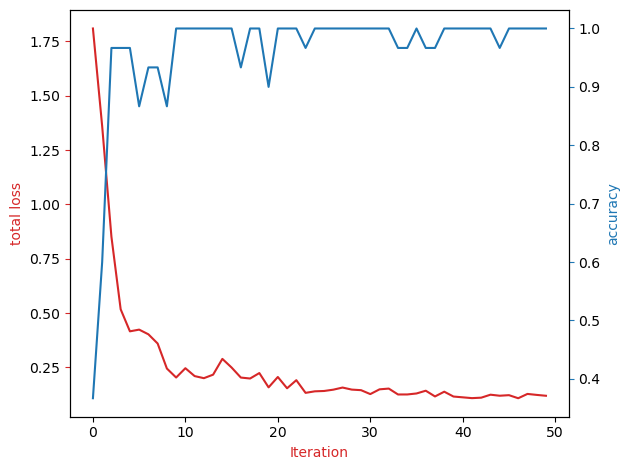

In [30]:
plot_stuff(loss_list,accuracy_list)

Load the model that performs best:  


In [31]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, n_classes)
model.load_state_dict(torch.load( "model.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  